# XAI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green'])

## Naive LIME implementation

<AxesSubplot: >

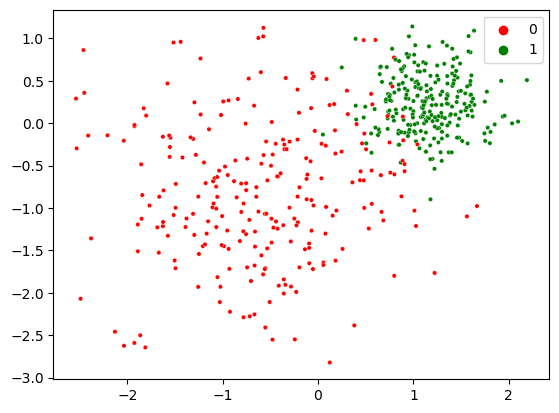

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=500, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2]
    ],
    cluster_std=[5, 2]
)
X = (X - X.mean())/X.std()

xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()

xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.vstack((xx.flatten(), yy.flatten())).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=10, palette=cmap.colors)

0.93

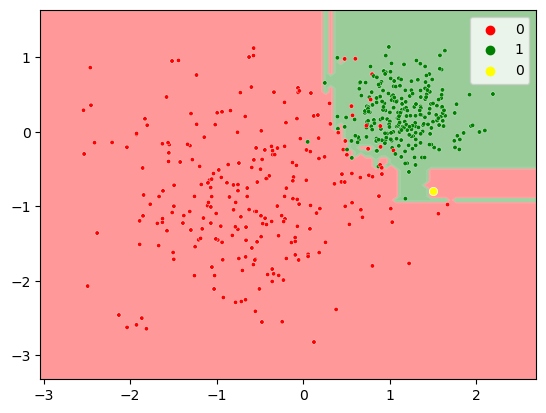

In [181]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)

y_pred = rf.predict(D)

plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap, alpha=0.4, antialiased=True)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=10, palette=cmap.colors)

# instance to be explained
x_lime = np.array([1.5, -0.8])
sns.scatterplot(x=[x_lime[0]], y=[x_lime[1]], hue=0, palette=['yellow'])

rf.score(X_test, y_test)

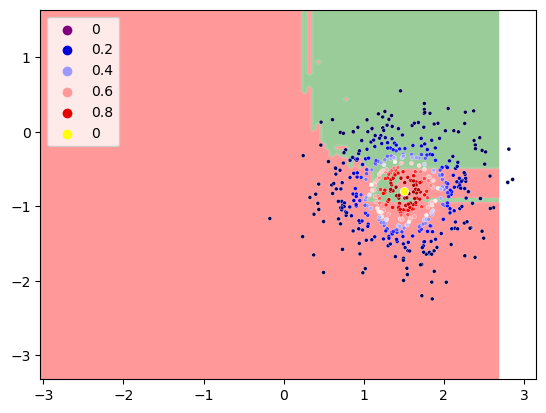

In [184]:
n_perturb = 500
sigma = 0.5

z = np.random.normal(x_lime, 0.5, size=(n_perturb, 2))

dist = np.linalg.norm(z - x_lime, axis=1)
pi_x = np.exp(- dist**2 / sigma**2)

sns.scatterplot(x=[x_lime[0]], y=[x_lime[1]], hue=0, palette=['purple'])
plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap, alpha=0.4, antialiased=True)

sns.scatterplot(x=z[:, 0], y=z[:, 1], s=8, hue=pi_x, palette="seismic")
sns.scatterplot(x=[x_lime[0]], y=[x_lime[1]], hue=0, palette=['yellow'])

X_lime = z
y_lime = rf.predict_proba(z)[:, 1]

array([-0.04206283,  0.73140177])

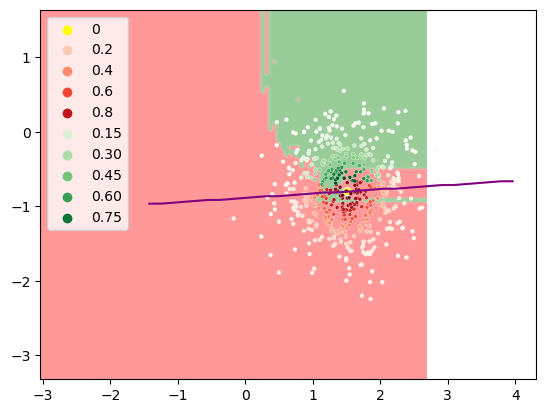

In [187]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_lime, y_lime, sample_weight=pi_x)

y_lr = lr.predict(X_lime)
y_lr = y_lr > 0.5

plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap, alpha=0.4, antialiased=True)
sns.scatterplot(x=[x_lime[0]], y=[x_lime[1]], hue=0, palette=['yellow'])

X_lime[y_lr == 0]

sns.scatterplot(x=X_lime[y_lr == 0, 0], y=X_lime[y_lr == 0, 1], s=8, hue=pi_x[y_lr == 0], palette='Reds')
sns.scatterplot(x=X_lime[y_lr == 1, 0], y=X_lime[y_lr == 1, 1], s=8, hue=pi_x[y_lr == 1], palette='Greens')

bound = D[np.abs(lr.coef_ @ D.T) < 0.005]
# bound = X_lime[np.abs(lr.coef_ @ X_lime.T) < 0.01]

plt.plot(x_lime[0] + bound[:, 0], x_lime[1] + bound[:, 1], c='purple')

lr.coef_

Above results of the coefficients of the linear model tell us what we need to do to shift the classification results to one of the classes. 

In this case, decreasing `x1` leads to the point being explained to be classified by the negative class, whereas increasing `x2` makes the sample point more positive.  

## Naive LIME class

In [193]:
from sklearn.linear_model import LinearRegression

class LIMExplainer:
    def __init__(self, n_perturb=500, sigma=2) -> None:
        self.weights = None
        self.n_perturb = n_perturb
        self.sigma = sigma

    def explain(self, X: np.ndarray, clf):
        self.weights = []

        for x in zip(X):
            z = np.random.normal(x, 1, size=(self.n_perturb, X.shape[1]))

            dist = np.linalg.norm(z - x, axis=1)
            pi_x = np.exp(- dist**2 / self.sigma**2)
            z_pred = clf.predict_proba(z)[:, 1]

            lr = LinearRegression().fit(z, z_pred, sample_weight=pi_x)
            self.weights.append(np.abs(lr.coef_))
        
        self.weights = np.array(self.weights)
        
        return self
    
    def feature_importance(self):
        return self.weights.sum(axis=0)**.5

In [202]:
lexpl = LIMExplainer().explain(X_test, rf)

Feature importance $\sqrt{\sum_{i=1}^N W_{ij}}$

In [203]:
lexpl.feature_importance()

array([4.23546861, 3.75772956])

<AxesSubplot: >

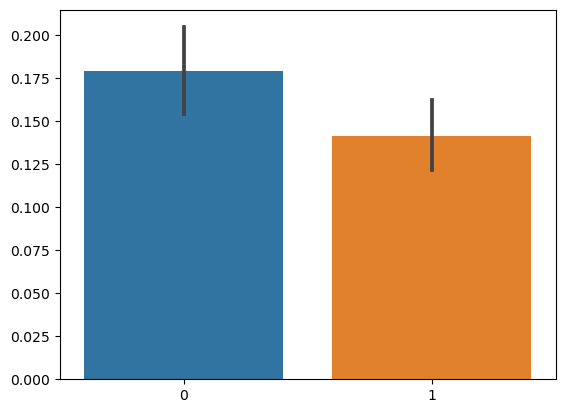

In [204]:
sns.barplot(lexpl.weights)

<AxesSubplot: >

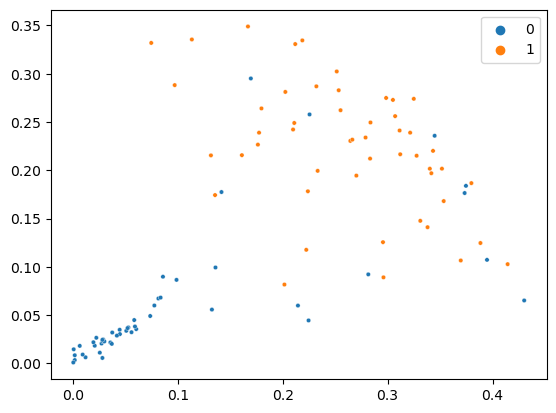

In [205]:
sns.scatterplot(x=lexpl.weights[:, 0], y=lexpl.weights[:, 1], s=10, hue=y_test)

We can see that the weights of the test set are roughly clustered based on their label.

Next, let's see what happens when we use `D` and plot the results

In [196]:
lexpl = LIMExplainer().explain(D, rf)

<AxesSubplot: >

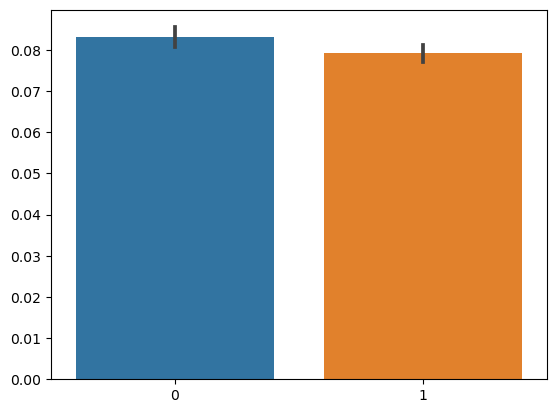

In [197]:
sns.barplot(lexpl.weights)

<AxesSubplot: >

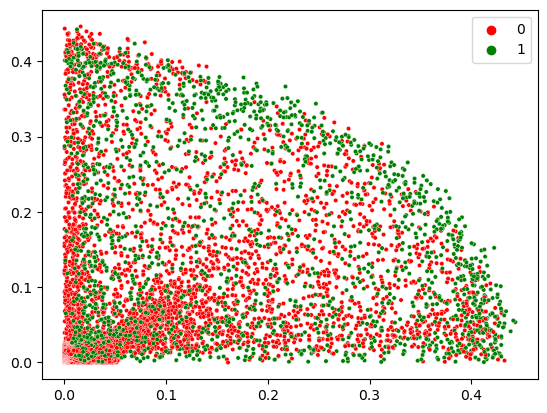

In [201]:
y_pred = rf.predict(D)
sns.scatterplot(x=lexpl.weights[:, 0], y=lexpl.weights[:, 1], s=10, hue=y_pred, palette=['r', 'g'])

## breast cancer dataset

In [96]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target
feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf = RandomForestClassifier().fit(X_train, y_train)

rf.score(X_test, y_test), f1_score(y_test, rf.predict(X_test))

(0.956140350877193, 0.9659863945578231)

In [107]:
lexpl = LIMExplainer().explain(X_test, rf)

In [108]:
feature_imp = pd.DataFrame({'feature': feature_names, 'importance': lexpl.feature_importance()})
feature_imp = feature_imp.sort_values(by='importance')[::-1]

<AxesSubplot: xlabel='importance', ylabel='feature'>

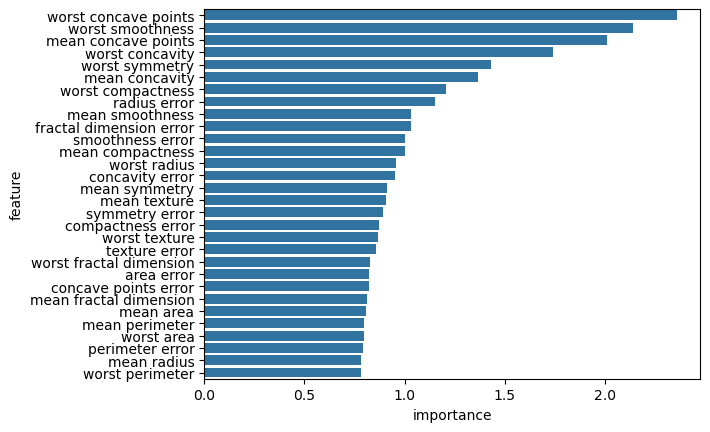

In [109]:
sns.barplot(feature_imp, x='importance', y='feature', color='C0')

we can see that using `worst concave points` (highest feature importance) as the only feature yields a good model

In [134]:
i = np.argmax(feature_names == 'worst concave points')
rf_test = RandomForestClassifier().fit(X_train[:, i:i+1], y_train)

rf_test.score(X_test[:, i:i+1], y_test), f1_score(y_test, rf_test.predict(X_test[:, i:i+1]))

(0.8947368421052632, 0.9178082191780821)

whereas using `mean fractal dimension` (lowest feature importance) yields a bad model

In [138]:
i = np.argmax(feature_names == 'mean fractal dimension')
rf_test = RandomForestClassifier().fit(X_train[:, i:i+1], y_train)

rf_test.score(X_test[:, i:i+1], y_test), f1_score(y_test, rf_test.predict(X_test[:, i:i+1]))

(0.6403508771929824, 0.7172413793103448)

Now using top 5 features with highest feature importance for model

In [148]:
i = feature_imp['feature'].iloc[:5].index
rf_test = RandomForestClassifier().fit(X_train[:, i], y_train)

rf_test.score(X_test[:, i], y_test), f1_score(y_test, rf_test.predict(X_test[:, i]))

(0.9298245614035088, 0.9459459459459458)

## LIME library

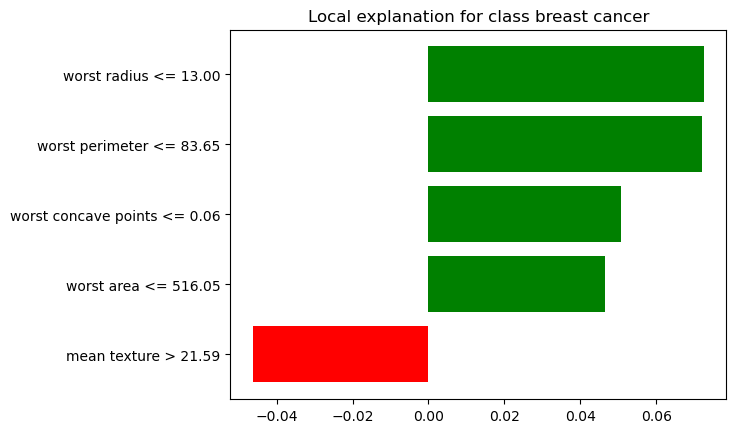

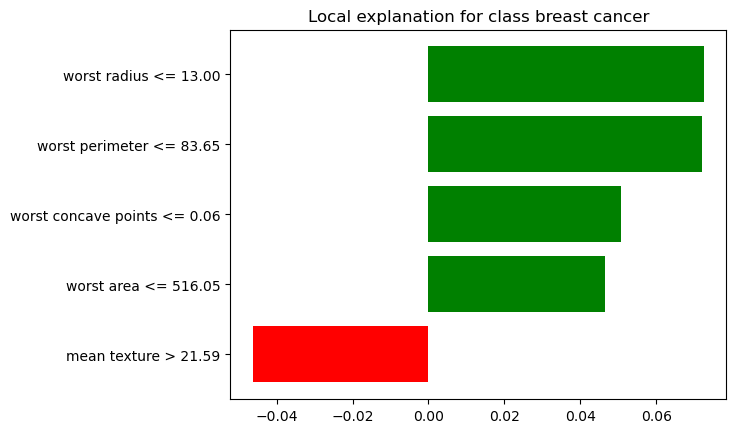

In [168]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_test, class_names=['no breast cancer', 'breast cancer'], feature_names=feature_names)

rf_lime = RandomForestClassifier().fit(X_train, y_train)
idx = 100
expl = explainer.explain_instance(X_test[idx], rf_lime.predict_proba, num_features=5)
expl.as_pyplot_figure()

In [169]:
expl.show_in_notebook()